# **Image Prompt & Grid Size**

In [19]:
image_dim = 256 # Possible 256, 512, 1024
base_model_name = "Dalle 2"
prompts = [
    # "A car"
    # "A cat sitting next to a bus.",
    # "A dog chasing a butterfly in a meadow.",
    # "A child holding a red balloon in a park.",
    # "A chef preparing sushi in a kitchen.",
    # "A bird perched on a windowsill with a view of the city skyline.",
    # "A woman reading a book under a large oak tree.",
    # "A black dog sitting beside 2 zebras, both looking in different directions.",
    # "A robot serving coffee in a cozy café.",
    # "A man playing the violin on a quiet beach at sunset.",
    # "A pair of glasses resting on a stack of books.",
    # "A horse grazing in a field with a mountain in the background.",
    # "A giraffe drinking water next to a small pond.",
    # "A boat floating on a calm lake with a forest in the distance.",
    # "A bicycle leaning against a lamppost in a quiet street.",
    "A painter working on a canvas with a cityscape in the background.",
    # "A picnic setup with a basket, blanket, and fruit on a sunny day.",
    # "A skateboard leaning against a graffiti-covered wall.",
    # "A piano in a large, empty concert hall.",
    # "A lighthouse standing tall on a rocky cliff by the ocean.",
    # "A telescope pointing towards the night sky filled with stars.",
    # 'there are a robot made of gold and a robot made of silver are standing on an exotic planet with a red butterfly flying around them.',
    #  "A red car passing by a fire hydrant on the sidewalk.",
    #  "A painting of a couple holding a yellow umbrella in a street on a rainy night. The woman is wearing a white dress and the man is wearing a blue suit.",
    # "An old time car is parked at the curb near a stop sign.",
    #  "A mirror, a white sink and a vase with red flowers in a bathroom with an artificial light.",
    #  "A black cow standing next to a 2 red damaged cars on a dirty lot.",
    # "A red car on a steep mountain road with pine trees and a clear sky.",
    # "A delivery truck and a mailbox positioned side by side on a quiet suburban street."

    ## Prompts for Testing Object and Prompt Generator, Color and Quantity
    # "A cow standing next to many damaged cars on a dirty lot.",
    # "Two black cows standing next to a many damaged cars on a dirty lot.",
    # "2 black cows standing next to a many damaged cars on a dirty lot.",
    # "Ten cows standing next to a many damaged blue cars on a dirty lot.",
    # "A black cow standing next to 2 damaged red cars on a dirty lot.",
]

# Prompt for Image Generation
recusive_diff_prompt = prompts[0]

def print_time_taken(start_time,process):
    print(f"Time taken for {process}: {int((time.time() - start_time) // 60)} minutes and {((time.time() - start_time) % 60):.0f} seconds")

#**Install dependencies for Stable / Dense Diffusion and YOLO & SAM**



In [20]:
import os
import time

if not os.path.exists('/content/sam_vit_h_4b8939.pth'):
  lib_time_start = time.time()
  # General Libraries
  !pip -q install tqdm openai

  # CLIP Libraries
  !pip -q install git+https://github.com/openai/CLIP.git

  # YOLO & SAM Libraries
  !pip -q install ultralytics segment_anything
  !wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

  # Print time taken to install libraries
  print_time_taken(lib_time_start,"installing libraries")

start_time = time.time()  # Start timer

# **Importing Libraries**

In [21]:
# General Libraries
import re
import torch
import matplotlib.pyplot as plt
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
from openai import OpenAI
import ast
import json
import shutil
from math import atan2, degrees
from PIL import Image
import clip
import gc
from google.colab import userdata
from tqdm.auto import tqdm
import random

# YOLO & SAM Libraries
import ultralytics
from ultralytics import YOLO
from segment_anything import sam_model_registry, SamPredictor
from IPython.display import display

# Dalle2 API Libraries
from io import BytesIO
import requests
import tempfile

# Check Ultralytics installation
ultralytics.checks()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Ultralytics YOLOv8.2.82 🚀 Python-3.10.12 torch-2.4.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 35.9/201.2 GB disk)


# **GPT 4o Mini**

In [22]:
def gpt_4o_mini(prompt, instruction):
    client = OpenAI(api_key=userdata.get("OPENAI_API_KEY"))
    messages = [
        {"role": "system", "content": instruction},
        {"role": "user", "content": prompt}
    ]
    try:
        completion = client.chat.completions.create(
            model="gpt-4o-mini",
            messages=messages
        )
        response = completion.choices[0].message.content
    except Exception as e:
        print(f"An error occurred while calling GPT 4o mini: {e}")
        response = ""
    return response

# **Combined**


In [23]:
def get_prompt_attributes_api(user_input):
    instruction = """
    You are an AI assistant skilled in identifying simple and drawable objects from a prompt. After identifying the objects, you simplify the prompt by focusing on a specific object, making it easier for stable diffusion to generate an image. Your task is to first extract the objects and then create a simplified prompt for each object. Additionally, identify the color and quantity of the objects.

    In addition to this, generate a separate background prompt that describes the environment, setting, or context of the scene, without changing the original prompt or the task of extracting objects. The background prompt should focus only on the background elements (such as scenery, lighting, and environment) that are necessary to generate a cohesive image.
    """

    prompt = f"""
    You are given a prompt.

    Extract simple and drawable objects from the following prompt, including any attributes of the objects. Avoid backgrounds, settings, or places. For example, if the prompt is "A damaged car moving on a road with a bright red fire hydrant," return ['damaged car', 'bright red fire hydrant']. Make sure that the objects remain singular even if they are plural in the original prompt.

    The original prompt describes a scene in which multiple objects are interacting with each other.

    After identifying the objects, your task is to:
    - Create a simpler prompt for each object.
    - Focus more on the given object and less on the other objects in the original prompt.
    - Make the simpler prompt short and to the point.

    Additionally, for each identified object, return:
    - The simplified prompt.
    - The color of the object (if mentioned in the original prompt, use that color; otherwise, use a random but realistic color in RGB format. For example, for a dog, use (165, 42, 42) for brown, or for a car, use any random RGB color), give it in a tuple of RGB colors.
    - The quantity of the objects you can judge from the original prompt if there is a number (2) or a number written in alphabets, then store a number (for example, 'three pens' means storing 3). Otherwise, judge from the prompt. If the number of objects is plural and not clearly specified, use whatever number you think suits the prompt.
      - Ensure the quantity matches the original prompt. It should be stored as a number even if a number is written in alphabets. If the plural form is used but no specific number is mentioned, choose a reasonable number greater than 2.

    **Background Prompt Generation**:
    Generate a background prompt that focuses on the environment, setting, or context of the scene described in the original prompt. Avoid including the main objects in the background prompt.

    Return a JSON object where each key is an identified object, and the value is an array containing:
    1. The simplified prompt.
    2. The color of the object.
    3. The quantity of the objects.

    Also, include a separate key for the background prompt in the returned JSON.

    The goal is to make it easier for Stable Diffusion to generate an image with the given object in a simpler and more straightforward layout, while also generating a background scene.

    Make sure to always return the result in a valid JSON format as follows:
    {{
        "Object Name 1": [simplified_prompt_1, color_1, quantity_1],
        "Object Name 2": [simplified_prompt_2, color_2, quantity_2],
        "Background Prompt": "The background description generated based on the original prompt"
    }}

    Prompt: "{user_input}"
    """

    gpt_4o_mini_response = gpt_4o_mini(prompt, instruction)
    try:
        # Attempt to parse the response as JSON
        result = json.loads(gpt_4o_mini_response)
    except json.JSONDecodeError as e:
        try:
            # Fallback to ast.literal_eval if JSON parsing fails
            result = ast.literal_eval(gpt_4o_mini_response)
        except (ValueError, SyntaxError) as e:
            print("gpt_4o_mini_response =", gpt_4o_mini_response)
            print(f"An error occurred while parsing the response: {e}")
            result = {}

    return result


# **Making Object & Editied Prompts arraies**

In [24]:
def get_prompt_attributes(user_input):
    # Get dictionary with objects as keys and their prompts, colors, and quantities as values
    objects_prompts_dictionary = get_prompt_attributes_api(user_input)

    # Extract the background prompt if it exists
    background_prompt = objects_prompts_dictionary.pop("Background Prompt", None)

    # Separate the keys (objects) into object_array
    object_array = list(objects_prompts_dictionary.keys())

    # Separate the values (arrays containing edited prompt, color, quantity) into separate arrays
    prompts_array = [value[0] for value in objects_prompts_dictionary.values()]
    colors_array = [value[1] for value in objects_prompts_dictionary.values()]
    quantities_array = [value[2] for value in objects_prompts_dictionary.values()]

    return object_array, prompts_array, colors_array, quantities_array, background_prompt

# Fetch the data
target_object_array, edited_prompts_array, target_colors_array, target_quantities_array, background_prompt = get_prompt_attributes(recusive_diff_prompt)

# Print arrays to verify
print("Original Prompt =", recusive_diff_prompt)
print("-----------------------------------")
print("Target Objects Array =", target_object_array)
print("-----------------------------------")
print("Target Edited Prompts Array:", edited_prompts_array)
print("-----------------------------------")
print("Target Colors Array:", target_colors_array)
print("-----------------------------------")
print("Target Quantities Array:", target_quantities_array)
print("-----------------------------------")
print("Background Prompt:", background_prompt)


Original Prompt = A painter working on a canvas with a cityscape in the background.
-----------------------------------
Target Objects Array = ['painter', 'canvas']
-----------------------------------
Target Edited Prompts Array: ['A painter', 'A canvas']
-----------------------------------
Target Colors Array: [(255, 204, 0), (255, 255, 255)]
-----------------------------------
Target Quantities Array: [1, 1]
-----------------------------------
Background Prompt: A vibrant cityscape with tall buildings and a clear blue sky.


# **Image Generation using SD3 API for Mask using Editied Prompts**

In [25]:
# Function to generate an image using DALL-E 2 API
def generate_image(display_text, prompt_given):
    print(display_text)

    client = OpenAI(api_key=userdata.get("OPENAI_API_KEY"))

    # API request to DALL-E 2
    response = client.images.generate(
        model="dall-e-2",
        prompt=prompt_given,
        size= f"{image_dim}x{image_dim}",
        quality="standard",
        n=1,  # Generate 1 image
    )

    # Handle the response
    if response and len(response.data) > 0:
        # Get the image URL from the response
        image_url = response.data[0].url

        # Download the image from the URL
        img_response = requests.get(image_url)
        if img_response.status_code == 200:
            image = Image.open(BytesIO(img_response.content))
            return image
        else:
            raise Exception(f"Failed to download the image from URL: {image_url}")
    else:
        raise Exception("DALL-E API call failed or returned no data.")


# List to hold images
images = []

# Making Image using Base model
base_model_image = generate_image(f"Generating Simple {base_model_name} image", recusive_diff_prompt)

# Making background_prompt image
background_image = generate_image("Generating Background image", background_prompt)

# Generate images for each edited prompt
for idx, edited_prompt in enumerate(edited_prompts_array):
    display_text = f"Generating edited_prompt {idx + 1}/{len(edited_prompts_array)}: {edited_prompt}"
    images.append(generate_image(display_text, edited_prompt))

Generating Simple Dalle 2 image
Generating Background image
Generating edited_prompt 1/2: A painter
Generating edited_prompt 2/2: A canvas


# **Loading YOLO & SAM**

In [26]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Load YOLOv8 model
model = YOLO('/content/yolov8n.pt')
model.to(device)

# Load SAM model
sam_checkpoint = "/content/sam_vit_h_4b8939.pth"
model_type = "vit_h"
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint).to(device)
predictor = SamPredictor(sam)

# **Helper Functions for Extracting Object Segments**

In [27]:
used_colors = set()  # Set to store used colors

def random_color():
    while True:
        color = tuple(np.random.randint(0, 255, size=3, dtype=np.uint8))
        if color not in used_colors:
            used_colors.add(color)
            return color

def get_relevant_object(target_object, detected_objects, original_prompt):
    instruction = "You are an AI assistant that helps identify the most relevant object from a list of detected objects based on a target object and the original prompt. This relevant object will be used by YOLO and SAM for segmentation purposes. Consider common associations, relationships, similar shapes, sizes, tasks, and appearances of objects. The relevant object cannot be 'None' and must be one of the detected objects."

    prompt = f"""
    Target Object: {target_object}
    Detected Objects: {detected_objects}
    Original Prompt: {original_prompt}

    Think about how objects are commonly related or associated. Consider relationships, similar-looking objects, objects with similar shapes or sizes, and objects that perform similar tasks.

    Here are some examples to guide you:
    1. If the target object is 'pencil' and the detected objects include 'pen', the relevant object might be 'pen' because they perform similar tasks.
    2. If the target object is 'car' and the detected objects include 'truck', the relevant object might be 'truck' because they are similar in shape and function.
    3. If the target object is 'dog' and the detected objects include 'cat', the relevant object might be 'cat' because they are both animals and similar in size.
    4. If the target object is 'salesman' and the detected objects include 'person', the relevant object might be 'person' because a salesman is a type of person.
    5. If the target object is 'toy' and the detected objects include 'robot', the relevant object might be 'robot' because toys and robots can be similar in shape.

    Your task is to determine which detected object is most relevant to the target object based on these factors. Return only the most relevant object from the list of detected objects without any explanation. The relevant object cannot be 'None' and must be one of the detected objects.
    """

    response = gpt_4o_mini(prompt, instruction)

    # Ensure response is not empty or None
    if response:
        response = response.strip()
        if response and response in detected_objects:
            return response

    # Fallback to the first detected object if no valid response is given
    print("GPT could not detect so Fallback case")
    return detected_objects[0]

# **Extracting Object Segments**

In [28]:
# Define segmentation function
def segment_image(image, target_object, edited_prompt,recusive_diff_prompt,object_color):
    print("Target Object =", target_object)
    original_object = target_object

    # Perform object detection using YOLOv8
    results = model.predict(source=image, conf=0.25, device="cuda")

    annotated_frame = results[0].plot()

    # Extract bounding boxes and class names
    detected_objects = []
    bboxes = []
    for result in results:
        boxes = result.boxes
        class_ids = result.boxes.cls
        detected_objects.extend([model.names[int(cls)] for cls in class_ids])
        bboxes.extend(boxes.xyxy.tolist())

    # Print the names of detected objects
    print("Detected Objects:", detected_objects)

    # Ensure the input image is in numpy array format
    if isinstance(image, Image.Image):
        image = np.array(image)
    elif isinstance(image, str):
        image = cv2.imread(image)

    if image is None:
        raise ValueError("The image could not be loaded. Please check the image path or object.")

    # Convert image to RGB
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    if len(detected_objects) == 0:
        print("No objects detected in the image.")
        display_images(image_rgb, annotated_frame, None, title=edited_prompt, status="No Objects in image", target_class_name=target_object)
        return None

    # Get the relevant object
    relevant_object = get_relevant_object(target_object, detected_objects, recusive_diff_prompt)
    print("Most relevant object to target object =",relevant_object)

    if relevant_object.lower() not in detected_objects:
        print(f"Object '{target_object}' not found in the image.")
        display_images(image_rgb, annotated_frame, None, title=edited_prompt, status="Object not found", target_class_name=target_object)
        return None

    # Updating target_object to relevant_object
    target_object = relevant_object

    predictor.set_image(image_rgb)

    masks_dict = {}

    # Perform segmentation for the target object
    for bbox, obj_name in zip(bboxes, detected_objects):
        if obj_name == target_object:
            input_box = np.array(bbox)

            masks, _, _ = predictor.predict(
                point_coords=None,
                point_labels=None,
                box=input_box[None, :],
                multimask_output=False,
            )

            # Store the binary mask in the dictionary
            segmentation_mask = masks[0]

            # Apply the mask to the original image with a unique color
            color = random_color()
            object_color[original_object] = color

            binary_mask = np.where(segmentation_mask > 0.5, 1, 0)

            # Get bounding box of the mask
            coords = np.argwhere(binary_mask)
            y0, x0 = coords.min(axis=0)
            y1, x1 = coords.max(axis=0) + 1

            # Crop the mask
            cropped_mask = binary_mask[y0:y1, x0:x1]
            colored_mask = np.zeros((cropped_mask.shape[0], cropped_mask.shape[1], 4), dtype=np.uint8)
            colored_mask[cropped_mask == 1] = color + (255,)

            # Display the colored cropped mask
            plt.imshow(colored_mask)
            plt.axis('off')
            plt.show()

            # Return type
            colored_mask_return = Image.fromarray(colored_mask, 'RGBA')

            # Displaying result
            display_images(image_rgb, annotated_frame, segmentation_mask,color, title=edited_prompt, status="Segmentation complete", target_class_name=target_object)

            return colored_mask_return

    print("Very big problem")
    return None

def display_images(original_image, out_image, segmentation_mask=None,segment_color=None, title="", status="", target_class_name=""):

    # Ensure original_image is in the correct format
    if isinstance(original_image, Image.Image):
        original_image = np.array(original_image)
    elif isinstance(original_image, str):
        original_image = cv2.imread(original_image)

    if original_image is None:
        raise ValueError("The original image could not be loaded. Please check the image path or object.")

    # Convert images to RGB for display
    original_rgb = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
    out_rgb = cv2.cvtColor(out_image, cv2.COLOR_BGR2RGB)

    if segmentation_mask is not None and segment_color is not None:
        # Creating extracted image
        extracted_image = np.zeros((original_image.shape[0], original_image.shape[1], 4), dtype=np.uint8)
        extracted_image[segmentation_mask] = [segment_color[2], segment_color[1], segment_color[0], 255]

        # Convert to RGBA format
        extracted_image = cv2.cvtColor(extracted_image, cv2.COLOR_BGRA2RGBA)

        extracted_rgb = cv2.cvtColor(np.array(extracted_image), cv2.COLOR_RGBA2RGB)
        combined_image = np.hstack((original_rgb, out_rgb, extracted_rgb))
    else:
        combined_image = np.hstack((original_rgb, out_rgb))

    # Use matplotlib to display the combined image with title
    plt.figure(figsize=(15, 5))
    plt.imshow(combined_image)
    plt.axis('off')
    display_text = f"Object: {target_class_name} || Prompt: {title} || Status: {status}"
    plt.title(display_text)
    plt.show()

# **Extracting Mask Segments**

Target Object = painter

0: 640x640 1 person, 9.7ms
Speed: 4.9ms preprocess, 9.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)
Detected Objects: ['person']
Most relevant object to target object = person


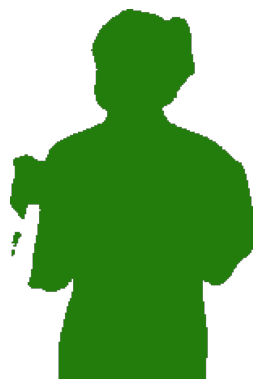

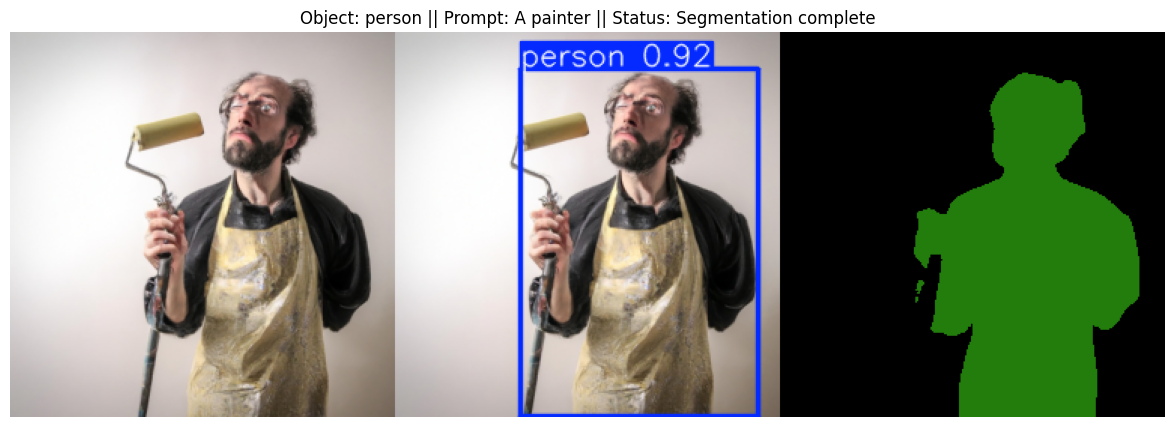

Target Object = canvas

0: 640x640 (no detections), 10.6ms
Speed: 3.1ms preprocess, 10.6ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)
Detected Objects: []
No objects detected in the image.


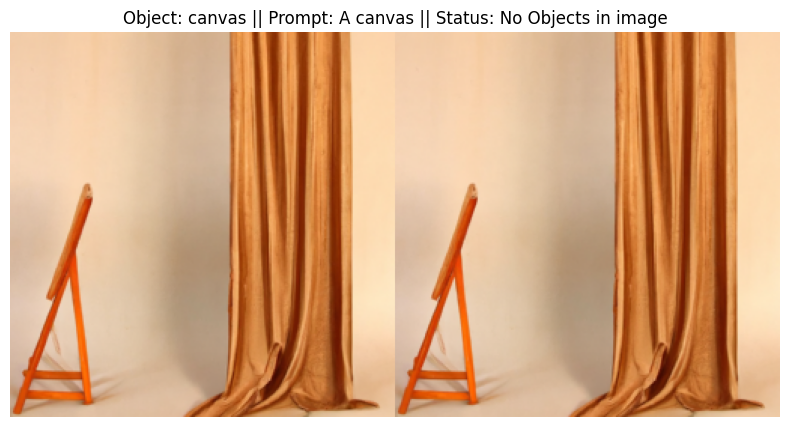

objects_array = ['painter']
extracted_images = {'painter': <PIL.Image.Image image mode=RGBA size=150x229 at 0x77FB60044460>}


In [29]:
objects_array = []
extracted_images = {}
object_color = {}

# Iterate through images, target objects, and edited prompts
for image, target_object, edited_prompt in zip(images, target_object_array, edited_prompts_array):
    mask = segment_image(image, target_object, edited_prompt, recusive_diff_prompt,object_color)
    if mask is not None:
        extracted_images[target_object] = mask
        objects_array.append(target_object)

print("objects_array =", objects_array)
print("extracted_images =", extracted_images)

if not extracted_images:
    raise ValueError("No images were extracted. Please check the input data.")

# Clear GPU memory for all objects
# clear_gpu_memory(model, predictor, sam)
del model
del predictor
del sam
gc.collect()
torch.cuda.empty_cache()

#**Getting Stacking order for extracted segments from GPT 4o mini**

In [30]:
def get_grid_positions_and_stack(prompt, objects_array):
    # Instruction for the AI assistant
    instruction = f"""
    You are an AI assistant that arranges objects in a {image_dim}x{image_dim} image based on a prompt and a list of extracted objects.
    Your task is to determine the position, size, and stacking order of each object within this image. Each object should be placed by defining its top-left corner (x, y) coordinates and its width and height, all in pixels relative to the image size.

    Use the following guidelines:
    - Larger objects should span significantly more image space and have larger width and height values.
    - Objects with natural vertical or horizontal orientations should reflect that in their positioning and dimensions.
    - Small objects (e.g., a ball) will likely have smaller width and height, whereas larger objects (e.g., a car or a tree) should have larger dimensions that take up a substantial portion of the image.

    The position and size of the objects should be calculated proportionally based on the {image_dim}x{image_dim} image size.
    """

    # Prompt content that includes details about the image, prompt, and objects
    prompt_content = f"""
    You are given an image of size {image_dim}x{image_dim} pixels. The image is divided into a grid of pixels, and your task is to position the extracted objects within this grid using pixel-based coordinates relative to the image dimensions.

    For each object, determine the following:
    - top_left_x: The x-coordinate of the top-left corner in pixels relative to the image
    - top_left_y: The y-coordinate of the top-left corner in pixels relative to the image
    - width: The width of the object in pixels relative to the image
    - height: The height of the object in pixels relative to the image

    Also, suggest a stacking order for the objects based on their relationship in the prompt to create a visually coherent scene.

    Here are a few examples:
    - If the object is a "table", it might be placed at (top_left_x={image_dim*0.1}, top_left_y={image_dim*0.2}, width={image_dim*0.5}, height={image_dim*0.4}).
    - If the object is a "tree", it might be placed at (top_left_x={image_dim*0.2}, top_left_y={image_dim*0.1}, width={image_dim*0.45}, height={image_dim*0.6}).
    - If the object is a "book", it might be placed at (top_left_x={image_dim*0.3}, top_left_y={image_dim*0.25}, width={image_dim*0.2}, height={image_dim*0.2}).

    The actual pixel values will depend on the total image size, but ensure the objects are proportionate to the image dimensions and occupy enough space to be visually significant.

    Return the result in a valid JSON format as follows:
    {{
        "grid_positions": {{
            "Object Name 1": {{
                "top_left_x": x_value,
                "top_left_y": y_value,
                "width": width_value,
                "height": height_value
            }},
            "Object Name 2": {{
                "top_left_x": x_value,
                "top_left_y": y_value,
                "width": width_value,
                "height": height_value
            }}
        }},
        "stacking_order": ["Object Name 1", "Object Name 2"]
    }}

    Make sure the JSON is correctly formatted.

    Prompt: {prompt}
    Objects: {objects_array}
    """

    print("prompt_content =", prompt_content)

    # Pass the instruction and the content to the GPT model
    gpt_4o_mini_response = gpt_4o_mini(prompt_content, instruction)

    # Clean and process the response
    cleaned_response = gpt_4o_mini_response.strip("```").strip()

    # Check for prefix issues like "json\n{...}"
    if cleaned_response.startswith("json"):
        cleaned_response = cleaned_response[len("json"):].strip()

    # Remove any comments in the response
    cleaned_response = '\n'.join(line for line in cleaned_response.splitlines() if not line.strip().startswith("//"))

    try:
        gpt_4o_mini_response = json.loads(cleaned_response)
        grid_positions_by_gpt = gpt_4o_mini_response["grid_positions"]
        stacking_order_by_gpt = gpt_4o_mini_response["stacking_order"]
    except json.JSONDecodeError as e:
        print("Error decoding JSON:", str(e))
        grid_positions_by_gpt = None
        stacking_order_by_gpt = None
    finally:
        print("---------------------------------------------")
        print("gpt_4o_mini_response =", gpt_4o_mini_response)
        print("---------------------------------------------")
        return grid_positions_by_gpt, stacking_order_by_gpt

# Example usage:
grid_positions_by_gpt, stacking_order = get_grid_positions_and_stack(recusive_diff_prompt, objects_array)
print("Grid Positions =", grid_positions_by_gpt)
print("Stacking Order =", stacking_order)


prompt_content = 
    You are given an image of size 256x256 pixels. The image is divided into a grid of pixels, and your task is to position the extracted objects within this grid using pixel-based coordinates relative to the image dimensions.

    For each object, determine the following:
    - top_left_x: The x-coordinate of the top-left corner in pixels relative to the image
    - top_left_y: The y-coordinate of the top-left corner in pixels relative to the image
    - width: The width of the object in pixels relative to the image
    - height: The height of the object in pixels relative to the image

    Also, suggest a stacking order for the objects based on their relationship in the prompt to create a visually coherent scene.

    Here are a few examples:
    - If the object is a "table", it might be placed at (top_left_x=25.6, top_left_y=51.2, width=128.0, height=102.4).
    - If the object is a "tree", it might be placed at (top_left_x=51.2, top_left_y=25.6, width=115.2, heigh

#**Making Composite Mask using stack order**

obj = painter
positions = {'top_left_x': 102.4, 'top_left_y': 128.0, 'width': 51.2, 'height': 102.4}
top_left_x = 102
top_left_y = 128
bottom_right_x = 153
bottom_right_y = 230
---------------------------------------------
---------------


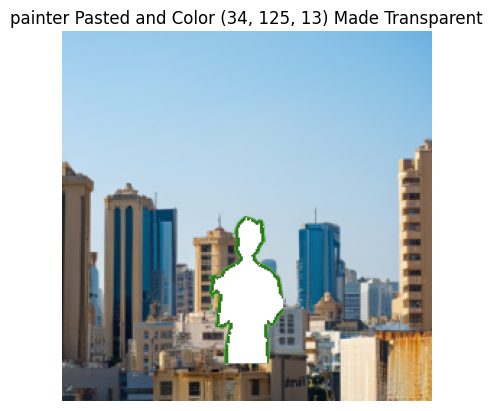

---------------
---------------


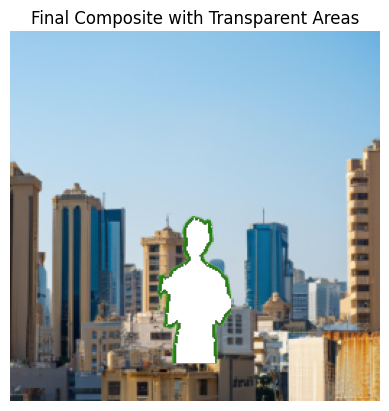

---------------


In [31]:
# Define the canvas size and create a canvas from the background image
canvas_size = (image_dim, image_dim)  # Example: 900x900 pixels, adjust as needed
canvas = background_image.convert("RGBA").copy()  # Ensure RGBA mode for transparency

def display_canvas(canvas_to_display, display_text):
    # Convert the canvas to a format that can be displayed using matplotlib
    canvas_np = np.array(canvas_to_display)

    # Display the result using matplotlib
    print("---------------")
    plt.imshow(canvas_np)
    plt.title(display_text)
    plt.axis('off')  # Hide axes
    plt.show()
    print("---------------")

def get_grid_coordinates(grid_positions):
    """Calculate top-left and bottom-right coordinates of the mask based on grid positions."""

    # Getting width and height
    width = int(grid_positions['width'])
    height = int(grid_positions['height'])

    # Calculate top-left coordinates
    top_left_x = int(grid_positions['top_left_x'])
    top_left_y = int(grid_positions['top_left_y'])

    # Calculating bottom right coordinates
    bottom_right_x = min(top_left_x + width, canvas_size[0])
    bottom_right_y = min(top_left_y + height, canvas_size[1])

    return top_left_x, top_left_y, bottom_right_x, bottom_right_y

# Function to make a specific color transparent on the canvas
def make_color_transparent(canvas, color_to_make_transparent):
    canvas_np = np.array(canvas)  # Convert to NumPy array for pixel manipulation

    # Get the RGBA values of the target color to make transparent
    r, g, b = color_to_make_transparent[:3]

    # Find all pixels matching the target color and make them transparent
    transparency_mask = (canvas_np[:, :, 0] == r) & (canvas_np[:, :, 1] == g) & (canvas_np[:, :, 2] == b)
    canvas_np[transparency_mask] = [0, 0, 0, 0]  # Set the pixels to fully transparent

    return Image.fromarray(canvas_np)

# Iterate through the stacking order to overlay images
for obj in stacking_order:
    # Get the image and grid positions
    img = extracted_images[obj]
    positions = grid_positions_by_gpt[obj]
    color_to_make_transparent = object_color[obj]

    # Calculate the grid coordinates
    top_left_x, top_left_y, bottom_right_x, bottom_right_y = get_grid_coordinates(positions)

    print("obj =",obj)
    print("positions =",positions)
    print("top_left_x =",top_left_x)
    print("top_left_y =",top_left_y)
    print("bottom_right_x =",bottom_right_x)
    print("bottom_right_y =",bottom_right_y)
    print("---------------------------------------------")

    # Validate the calculated dimensions
    new_width = max(1, bottom_right_x - top_left_x)
    new_height = max(1, bottom_right_y - top_left_y)

    # Resize the image to fit within the calculated grid area
    resized_img = img.resize((new_width, new_height), Image.LANCZOS)

    # Paste the rotated image onto the canvas
    canvas.paste(resized_img, (top_left_x, top_left_y), resized_img)

    # Make the color on the canvas transparent
    canvas = make_color_transparent(canvas, color_to_make_transparent)

    # Display the canvas after making the color transparent
    display_canvas(canvas, f"{obj} Pasted and Color {color_to_make_transparent} Made Transparent")

display_canvas(canvas, "Final Composite with Transparent Areas")

# **Editing using DALL·E 2**

---------------


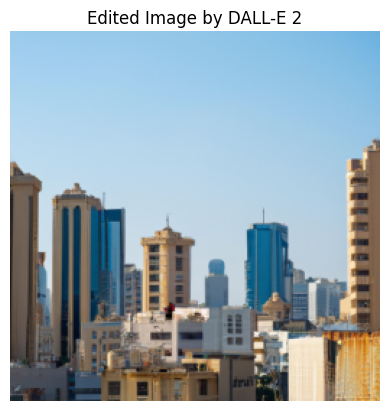

---------------


In [32]:
def dalle2_edit_image(background_image, mask_image, prompt):
    client = OpenAI(api_key=userdata.get("OPENAI_API_KEY"))
    # Save the background image to a temporary file
    with tempfile.NamedTemporaryFile(suffix=".png") as temp_background:
        background_image.save(temp_background.name, format="PNG")

        # Save the mask image to a temporary file
        with tempfile.NamedTemporaryFile(suffix=".png") as temp_mask:
            mask_image.save(temp_mask.name, format="PNG")

            # Call DALL-E 2 API to edit the image
            response = client.images.edit(
                model="dall-e-2",
                image=open(temp_background.name, "rb"),
                mask=open(temp_mask.name, "rb"),
                prompt=prompt,
                n=1,  # Generate 1 image
                size= f"{image_dim}x{image_dim}",
            )

            if response and len(response.data) > 0:
                # Get the image URL from the response
                image_url = response.data[0].url

                # Download the edited image from the URL
                img_response = requests.get(image_url)
                if img_response.status_code == 200:
                    edited_image = Image.open(BytesIO(img_response.content))
                    return edited_image
                else:
                    raise Exception(f"Failed to download the image from URL: {image_url}")
            else:
                raise Exception("DALL-E 2 API call failed or returned no data.")

edited_image = dalle2_edit_image(background_image, canvas, recusive_diff_prompt)

# Display the edited image
display_canvas(edited_image, "Edited Image by DALL-E 2")

# **Loading CLIP Model**


In [33]:
model_path = "/content/clip_model.pt"

if os.path.exists(model_path):
    clip_model, preprocess = torch.load(model_path)
else:
    clip_model, preprocess = clip.load("ViT-B/32", device=device)
    torch.save((clip_model, preprocess), model_path)

# **Calculating Clip Score**

In [34]:
def calculate_clip_score(image, prompt, model_name="ViT-B/32", device=None):
    # Set device
    if device is None:
        device = "cuda" if torch.cuda.is_available() else "cpu"

    # Preprocess the image
    image_processed = preprocess(image).unsqueeze(0).to(device)

    # Tokenize the prompt
    text_input = clip.tokenize([prompt]).to(device)

    # Calculate the CLIP score
    with torch.no_grad():
        image_features = clip_model.encode_image(image_processed)
        text_features = clip_model.encode_text(text_input)

        # Normalize the features
        image_features /= image_features.norm(dim=-1, keepdim=True)
        text_features /= text_features.norm(dim=-1, keepdim=True)

        # Calculate the cosine similarity between the image and the text prompt
        similarity_score = (image_features @ text_features.T).cpu().numpy()[0][0]

    # Return the similarity score
    return similarity_score


# **Calculating Clip Score for DallE-2 Edited Images**

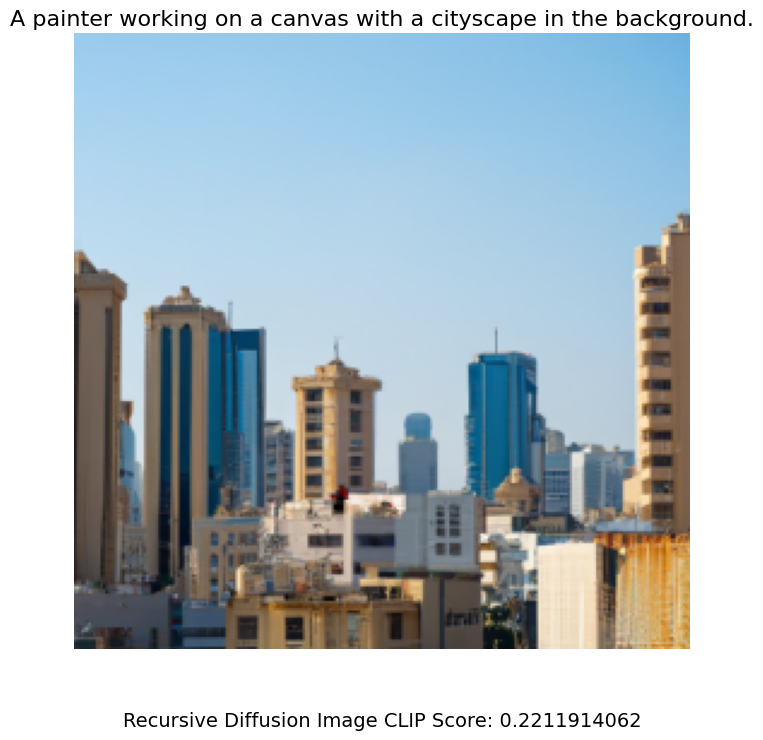

---------------------------------------------


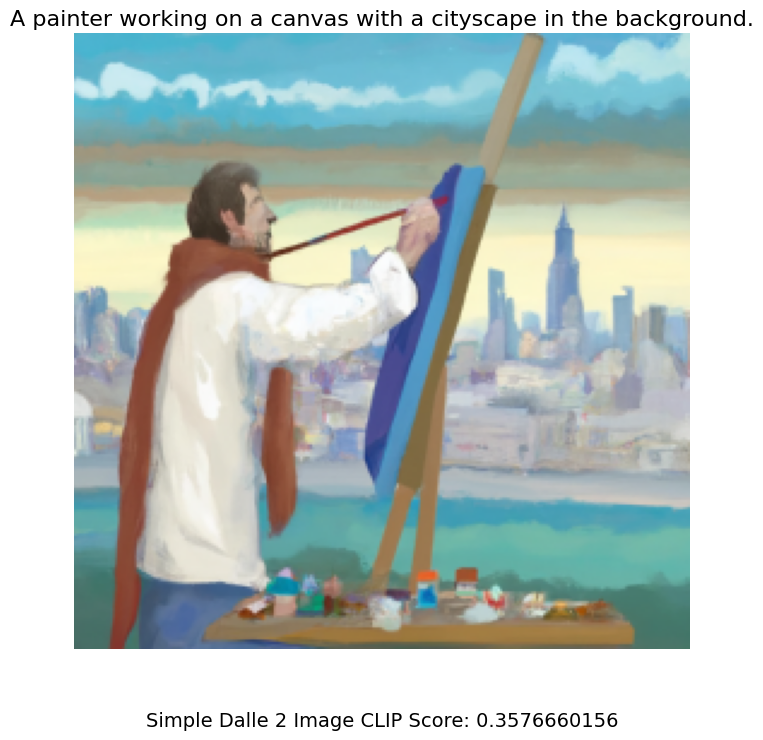

---------------------------------------------


In [35]:
def display_image_with_score(image,title):
    # Convert the image to a format that can be displayed using matplotlib
    image_np = np.array(image)

    # Create a figure and axes
    fig, ax = plt.subplots(figsize=(8, 8))

    # Display the image
    ax.imshow(image_np)

    # Set the title as the prompt
    ax.set_title(recusive_diff_prompt, fontsize=16)

    clip_score=calculate_clip_score(image,recusive_diff_prompt)

    # Display the CLIP score below the image
    ax.text(0.5, -0.1, f"{title} Image CLIP Score: {clip_score:.10f}", fontsize=14, ha='center', va='top', transform=ax.transAxes)

    # Hide axes
    ax.axis('off')

    # Show the plot
    plt.show()
    print("---------------------------------------------")

display_image_with_score(edited_image,"Recursive Diffusion")
display_image_with_score(base_model_image,"Simple "+base_model_name)


In [36]:
print_time_taken(start_time,"complete code")

Time taken for complete code: 1 minutes and 23 seconds
